In [ ]:
from prophet import Prophet 
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import seaborn as sns
import plotly
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
import math
sns.set()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df=pd.read_csv('/content/drive/MyDrive/data-penjualan-urea.csv')
df.head()

,Datum,Urea,Year,Month
0,1/1/2021,"1,456",2021.0,1.0
1,1/2/2021,"2,016",2021.0,1.0
2,1/3/2021,"2,678",2021.0,1.0
3,1/4/2021,"1,670",2021.0,1.0
4,1/5/2021,"2,278",2021.0,1.0


In [ ]:
df.Datum = pd.to_datetime(df['Datum'])
df['Urea'] = df['Urea'].astype(str).str.replace(',', '').astype(float)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Datum   730 non-null    datetime64[ns]
 1   Urea    730 non-null    float64       
 2   Year    730 non-null    float64       
 3   Month   730 non-null    float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 23.0 KB


In [ ]:
df_train  = df[df['Datum']<'2022-01-01']
df_test   = df[df['Datum']>'2022-01-01'] 

In [ ]:
train = df_train[['Datum','Urea']]

In [ ]:
test  = df_test[['Datum','Urea']]

In [ ]:
train = train.rename(columns={'Datum':'ds', 'Urea':'y'})

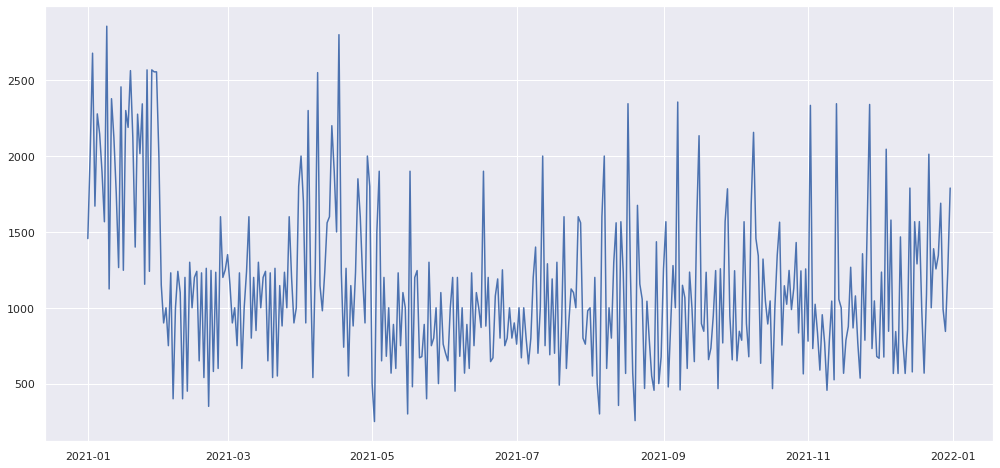

In [ ]:
plt.figure(figsize=(17,8))
plt.plot(train['ds'], train['y'])

In [ ]:
model = Prophet()
model.fit(train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnilcj2n8/eyjflda4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnilcj2n8/pb6mqrwb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90356', 'data', 'file=/tmp/tmpnilcj2n8/eyjflda4.json', 'init=/tmp/tmpnilcj2n8/pb6mqrwb.json', 'output', 'file=/tmp/tmpnilcj2n8/prophet_modelj4um2slo/prophet_model-20230126133301.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:33:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:33:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:

future = model.make_future_dataframe(365)
forecast = model.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-01-01,1533.614880,943.523340,2188.969925,1533.614880,1533.614880,-2.039307,-2.039307,-2.039307,-2.039307,-2.039307,-2.039307,0.0,0.0,0.0,1531.575573
1,2021-01-02,1530.394764,976.656238,2242.635205,1530.394764,1530.394764,64.420615,64.420615,64.420615,64.420615,64.420615,64.420615,0.0,0.0,0.0,1594.815378
2,2021-01-03,1527.174647,910.929622,2158.516920,1527.174647,1527.174647,-16.648357,-16.648357,-16.648357,-16.648357,-16.648357,-16.648357,0.0,0.0,0.0,1510.526290
3,2021-01-04,1523.954531,824.534883,2122.156779,1523.954531,1523.954531,-59.169676,-59.169676,-59.169676,-59.169676,-59.169676,-59.169676,0.0,0.0,0.0,1464.784854
4,2021-01-05,1520.734414,905.794767,2187.360823,1520.734414,1520.734414,32.521573,32.521573,32.521573,32.521573,32.521573,32.521573,0.0,0.0,0.0,1553.255987


In [ ]:
print('RMSE: %f' % np.sqrt(np.mean((forecast.loc[:len(forecast['yhat']), 'yhat']-train['y'])**2)) )

RMSE: 486.587158


In [ ]:
py.iplot([
    go.Scatter(x=train['ds'], y=train['y'], name='Actual'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='Predicted'),])

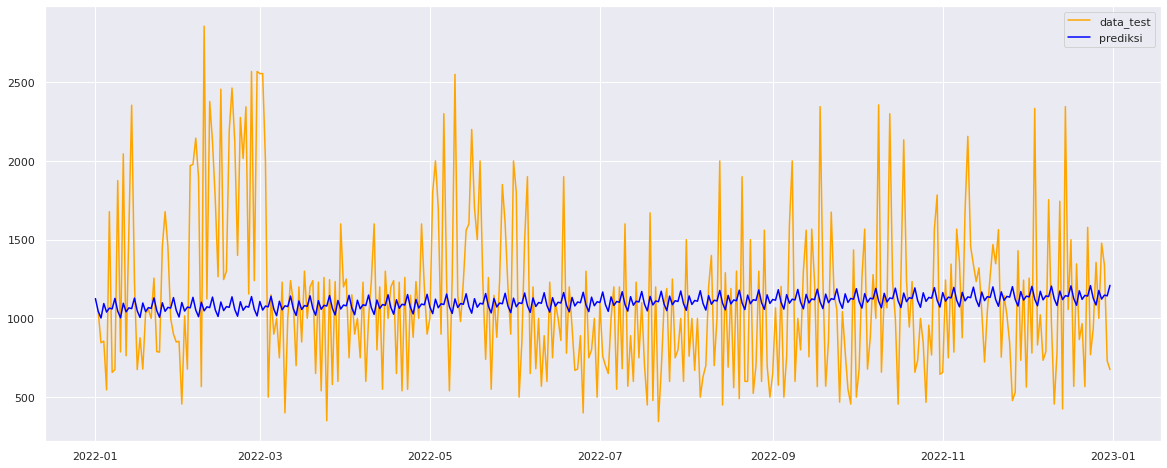

In [ ]:

predict = forecast[forecast['ds']>='2022-01-01']
#Melihat perbandingan data test dengan yhat
plt.figure(figsize=(20,8))
plt.plot(test['Datum'], test['Urea'], label="data_test", color='orange')
plt.plot(predict['ds'], predict['yhat'], label="prediksi", color='blue')
plt.legend()

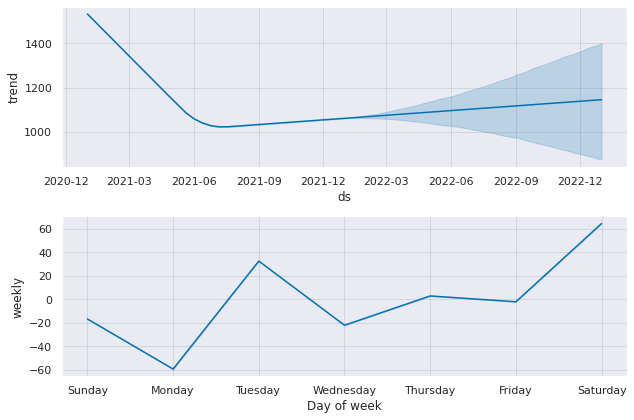

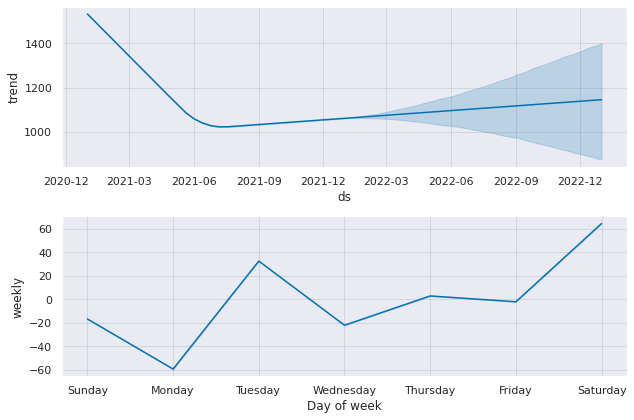

In [ ]:
model.plot_components(forecast)

In [ ]:
dff=pd.DataFrame(list(zip(train['y'],predict['yhat'])),columns=['Actual','Predicted'])
dff["MAPE (Mean Absolute Percentage Error)"]=(abs((dff['Actual']-dff['Predicted']))/dff['Actual'])*100
      
dff = dff.apply (pd.to_numeric, errors='coerce') #To drop NaN values

print (dff.dropna(inplace=True))


None


In [ ]:
lst=dff['MAPE (Mean Absolute Percentage Error)'].tolist()

for i in range(len(lst)):
    if lst[i]==float('inf'):
        lst[i]=0
    
       
#print(lst)
dff['MAPE (Mean Absolute Percentage Error)']=lst
dff.head(10)

,Actual,Predicted,MAPE (Mean Absolute Percentage Error)
0,1456.0,1125.678636,22.686907
1,2016.0,1044.841048,48.172567
2,2678.0,1002.551110,62.563439
3,1670.0,1094.473742,34.462650
4,2278.0,1040.196779,54.337279
5,2145.0,1065.316859,50.334878
6,1894.0,1060.607010,44.001742
7,1567.0,1127.298314,28.060095
8,2856.0,1046.460725,63.359218
9,1124.0,1004.170787,10.660962


Membuat Model ARIMA 

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning:


statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)




RMSE error: 671.5306208851337


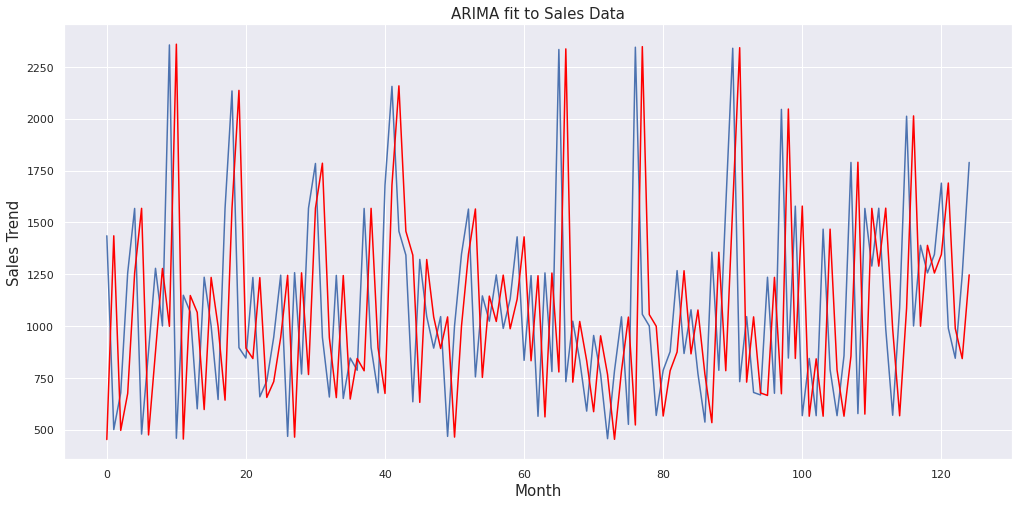

In [ ]:
X = train['y'].values

split = int(0.66*len(X))
train, test = X[0:split], X[split:]

history = [x for x in train]
predictions = []
for t in range(len(test)):
	model = ARIMA(history, order=(0,1,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
    
	obs = test[t]
	history.append(obs)
 
mse = mean_squared_error(test, predictions)
RMSE = math.sqrt(mse)

print(f"RMSE error: {RMSE}")

plt.figure(figsize=(17,8))
plt.plot(test)
plt.plot(predictions, color='red')
plt.title("ARIMA fit to Sales Data",fontsize=15)
plt.xlabel("Month", fontsize=15)
plt.ylabel("Sales Trend", fontsize=15)
plt.show()